In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
resnet_pretrained = models.resnet50(pretrained=True)
nn.Conv2d = Conv2d_Attn
resnet_attn = models.resnet50()
resnet_attn.load_state_dict(resnet_pretrained.state_dict(), strict=False)

In [5]:
# This block turns 'layer1.0.downsample.0.weight' to 'layer1[0].downsample[0].weight'
param_keys = list(resnet_attn.state_dict().keys())
formatted_keys = []
for k in param_keys:
    found = re.findall(r'\.[\d]{1,2}\.', k)
    if len(found):
        for f in found:
            k = k.replace(f, '[{}].'.format(f.strip('.')))
    formatted_keys.append(k)

In [6]:
# This block turn off gradient up for all params except attn_weights
def turn_off_grad_except(lst=[]):
    for k in formatted_keys:
        obj = eval('resnet_attn.'+k)
        for kw in lst:
            if not kw in k:
                obj.requires_grad = False
            else:
                obj.requires_grad = True

In [7]:
resnet_attn.fc = nn.Linear(resnet_attn.fc.in_features, 144)

Start training

In [8]:
batch_size = 32
# batch_size = 64

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.ImageFolder(root='../data/val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [10]:
total_imgs = len(trainset.imgs)

In [11]:
resnet_attn = resnet_attn.cuda()

In [12]:
total_attn_params = 0
for k in formatted_keys:
    obj = eval('resnet_attn.'+k)
    if 'attn_weights' in k:
        total_attn_params += np.prod(obj.shape)
print("Total number of attention parameters", total_attn_params)

Total number of attention parameters 13385920


We want the attention parameters to diverge from 1, therefore we penalize element-wise square loss as $\lambda (1 \times \text{# params} - (x - 1)^2)$

But this is too big a number,
let's try: 
$- (x - 1)^2$ for now

In [13]:
_lambda = 1 #set default

In [14]:
def get_params_objs(name, net='resnet_attn'):
    res = []
    for k in formatted_keys:
        obj = eval(f'{net}.'+k)
        if name in k:
            res.append(obj)
    return res

In [15]:
def compute_attn_loss(n_params=26560):
    attns = get_params_objs('attn_weights')
#     penalty = sum([torch.abs(t - 1,2).mean() for t in attns])
    penalty = sum([torch.norm(t, p=1) for t in attns])/float(total_attn_params)
    return _lambda*(penalty)

In [16]:
compute_attn_loss()

Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [17]:
print_every = 50

In [18]:
def score_top3(train=True, val=True, partial=True, frac=4):
    if train:
        correct_count = 0
        num_imgs = len(trainset)
        if partial:
            part = len(trainset)//frac
            total = 0
            num_imgs = part
        
        for inp, label in tqdm(iter(trainloader)):
            _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
            lab = Variable(label).cuda()
            lab_expand = lab.unsqueeze(1).expand_as(idx)
            correct_count += int((idx == lab_expand).sum())
            
            if partial:
                total += batch_size
                if total >= part:
                    break
            
        print({'Train Accuracy': correct_count/num_imgs})
    
    if val:
        correct_count = 0
        for inp, label in tqdm(iter(valloader)):
            _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
            lab = Variable(label).cuda()
            lab_expand = lab.unsqueeze(1).expand_as(idx)
            correct_count += int((idx == lab_expand).sum())
        print({'Val Accuracy': correct_count/len(valset)})

In [19]:
def plot_attn_hist():
    attns = get_params_objs('attn_weights')
    attns = torch.cat([attn.view(-1).squeeze() for attn in attns])
    attns_arr = attns.data.cpu().numpy()
    plt.hist(attns_arr)

In [20]:
def train(k=1, add_attn=True, score=True, plot_hist=False):
    cls_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_attn.parameters()))
    
    for j in range(k):
        running_loss = 0.0
        running_attn_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

            optimizer.zero_grad()
            outputs = resnet_attn(inputs)
            loss = cls_criterion(outputs, labels)
            attn_loss = compute_attn_loss()
            if add_attn:
                loss += attn_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]
            running_attn_loss += attn_loss.data[0]

            if i % print_every == 0:
                print('[%5d] iter, [%2f] epoch, avg loss: %.3f, attn_loss: %.5f ' %
                      (i + 1, i*batch_size/total_imgs, running_loss/print_every, running_attn_loss/print_every))
                running_loss = 0.0
                running_attn_loss = 0.0
        if score:
            score_top3()
        if plot_hist:
            plot_attn_hist()
            plt.show()

In [21]:
turn_off_grad_except(['fc'])
resnet_attn.eval() # Turn on batchnorm
train(1, add_attn=False, plot_hist=False)

[    1] iter, [0.000000] epoch, avg loss: 0.100, attn_loss: 0.02000 
[   51] iter, [0.196054] epoch, avg loss: 4.282, attn_loss: 1.00000 
[  101] iter, [0.392109] epoch, avg loss: 3.521, attn_loss: 1.00000 
[  151] iter, [0.588163] epoch, avg loss: 3.227, attn_loss: 1.00000 
[  201] iter, [0.784218] epoch, avg loss: 3.111, attn_loss: 1.00000 
[  251] iter, [0.980272] epoch, avg loss: 2.955, attn_loss: 1.00000 


 25%|██▍       | 63/256 [00:15<00:48,  3.98it/s]

{'Train Accuracy': 0.5877450980392157}



100%|██████████| 55/55 [00:13<00:00,  3.97it/s]

{'Val Accuracy': 0.5342075256556442}


In [22]:
turn_off_grad_except(['attn_weights'])
resnet_attn.eval() # Turn on batchnorm
# _lambda=1
train(3, add_attn=True, plot_hist=False)

[    1] iter, [0.000000] epoch, avg loss: 0.070, attn_loss: 0.02000 
[   51] iter, [0.196054] epoch, avg loss: 3.312, attn_loss: 0.99968 
[  101] iter, [0.392109] epoch, avg loss: 3.148, attn_loss: 0.99893 
[  151] iter, [0.588163] epoch, avg loss: 3.114, attn_loss: 0.99814 
[  201] iter, [0.784218] epoch, avg loss: 3.083, attn_loss: 0.99733 
[  251] iter, [0.980272] epoch, avg loss: 2.994, attn_loss: 0.99651 


 25%|██▍       | 63/256 [00:16<00:49,  3.92it/s]

{'Train Accuracy': 0.7666666666666667}



100%|██████████| 55/55 [00:14<00:00,  3.92it/s]

{'Val Accuracy': 0.6322690992018244}


[    1] iter, [0.000000] epoch, avg loss: 0.048, attn_loss: 0.01992 
[   51] iter, [0.196054] epoch, avg loss: 2.647, attn_loss: 0.99561 
[  101] iter, [0.392109] epoch, avg loss: 2.637, attn_loss: 0.99480 
[  151] iter, [0.588163] epoch, avg loss: 2.595, attn_loss: 0.99400 
[  201] iter, [0.784218] epoch, avg loss: 2.601, attn_loss: 0.99319 
[  251] iter, [0.980272] epoch, avg loss: 2.544, attn_loss: 0.99238 


 25%|██▍       | 63/256 [00:16<00:49,  3.93it/s]

{'Train Accuracy': 0.859313725490196}



100%|██████████| 55/55 [00:14<00:00,  3.93it/s]

{'Val Accuracy': 0.6465222348916762}


[    1] iter, [0.000000] epoch, avg loss: 0.044, attn_loss: 0.01984 
[   51] iter, [0.196054] epoch, avg loss: 2.211, attn_loss: 0.99148 
[  101] iter, [0.392109] epoch, avg loss: 2.179, attn_loss: 0.99068 
[  151] iter, [0.588163] epoch, avg loss: 2.160, attn_loss: 0.98988 
[  201] iter, [0.784218] epoch, avg loss: 2.203, attn_loss: 0.98909 
[  251] iter, [0.980272] epoch, avg loss: 2.222, attn_loss: 0.98830 


 25%|██▍       | 63/256 [00:16<00:49,  3.92it/s]

{'Train Accuracy': 0.9107843137254902}



100%|██████████| 55/55 [00:14<00:00,  3.91it/s]

{'Val Accuracy': 0.6522234891676169}


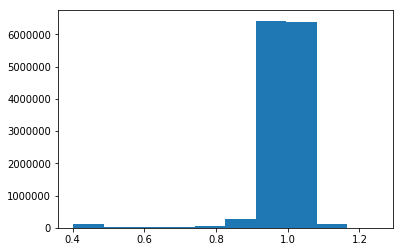

In [23]:
plot_attn_hist()

In [24]:
turn_off_grad_except(['bn'])
resnet_attn.train() 
# _lambda=1
train(1, add_attn=False, plot_hist=False)

[    1] iter, [0.000000] epoch, avg loss: 0.045, attn_loss: 0.01976 
[   51] iter, [0.196054] epoch, avg loss: 2.271, attn_loss: 0.98782 
[  101] iter, [0.392109] epoch, avg loss: 2.100, attn_loss: 0.98782 
[  151] iter, [0.588163] epoch, avg loss: 1.971, attn_loss: 0.98782 
[  201] iter, [0.784218] epoch, avg loss: 1.892, attn_loss: 0.98782 
[  251] iter, [0.980272] epoch, avg loss: 1.911, attn_loss: 0.98782 


 25%|██▍       | 63/256 [00:16<00:50,  3.79it/s]

{'Train Accuracy': 0.7651960784313725}



100%|██████████| 55/55 [00:14<00:00,  3.79it/s]

{'Val Accuracy': 0.6237172177879133}


In [25]:
turn_off_grad_except(['fc'])
resnet_attn.eval() 
# _lambda=1
train(1, add_attn=False, plot_hist=False)

[    1] iter, [0.000000] epoch, avg loss: 0.037, attn_loss: 0.01976 
[   51] iter, [0.196054] epoch, avg loss: 1.857, attn_loss: 0.98782 
[  101] iter, [0.392109] epoch, avg loss: 1.545, attn_loss: 0.98782 
[  151] iter, [0.588163] epoch, avg loss: 1.331, attn_loss: 0.98782 
[  201] iter, [0.784218] epoch, avg loss: 1.380, attn_loss: 0.98782 
[  251] iter, [0.980272] epoch, avg loss: 1.335, attn_loss: 0.98782 


 25%|██▍       | 63/256 [00:16<00:49,  3.92it/s]

{'Train Accuracy': 0.9009803921568628}



100%|██████████| 55/55 [00:14<00:00,  3.91it/s]

{'Val Accuracy': 0.6584948688711516}


In [26]:
turn_off_grad_except(['attn_weights'])
resnet_attn.eval() # Turn on batchnorm
# _lambda=1
train(1, add_attn=True, plot_hist=False)

[    1] iter, [0.000000] epoch, avg loss: 0.032, attn_loss: 0.01976 
[   51] iter, [0.196054] epoch, avg loss: 1.863, attn_loss: 0.98751 
[  101] iter, [0.392109] epoch, avg loss: 1.816, attn_loss: 0.98688 
[  151] iter, [0.588163] epoch, avg loss: 1.814, attn_loss: 0.98621 
[  201] iter, [0.784218] epoch, avg loss: 1.764, attn_loss: 0.98553 
[  251] iter, [0.980272] epoch, avg loss: 1.794, attn_loss: 0.98484 


 25%|██▍       | 63/256 [00:16<00:49,  3.92it/s]

{'Train Accuracy': 0.9647058823529412}



100%|██████████| 55/55 [00:14<00:00,  3.93it/s]

{'Val Accuracy': 0.6704675028506272}


Checkpoint, accuracy above is best so far but with very high train accuracy

In [37]:
def test():
    testset = torchvision.datasets.ImageFolder(root='../data/test', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    correct_count = 0
    for inp, label in tqdm(iter(testloader)):
        _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
        lab = Variable(label).cuda()
        lab_expand = lab.unsqueeze(1).expand_as(idx)
        correct_count += int((idx == lab_expand).sum())
    print({'Val Accuracy': correct_count/len(testset)})

In [38]:
test()

100%|██████████| 53/53 [00:13<00:00,  4.01it/s]

{'Val Accuracy': 0.6736401673640168}


top 1

In [40]:
def compute_top1(set_='test'):    
    testset = torchvision.datasets.ImageFolder(root='../data/{}'.format(set_), transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    correct_count = 0
    for inp, label in tqdm(iter(testloader)):
        _, idx = resnet_attn(Variable(inp).cuda()).max(1)
        lab = Variable(label).cuda()
        correct_count += int((idx == lab).sum())
    print({'{} Accuracy'.format(set_): correct_count/len(testset)})

In [41]:
compute_top1()

100%|██████████| 53/53 [00:13<00:00,  4.02it/s]

{'test Accuracy': 0.4722056186491333}


In [42]:
compute_top1('train')

100%|██████████| 256/256 [01:04<00:00,  3.99it/s]

{'train Accuracy': 0.8729322386962383}


In [43]:
compute_top1('val')

100%|██████████| 55/55 [00:13<00:00,  3.94it/s]

{'val Accuracy': 0.4692132269099202}


In [44]:
torch.save(resnet_attn, 'l1-norm-top3-67.pkl')